# Анализ убытков приложения ProcrastinatePRO+

### Описание проекта

Вы - маркетинговый аналитик развлекательного приложения Procrastinate Pro+. Несколько прошлых месяцев ваш бизнес постоянно нес убытки - в привлечение пользователей была вложена куча денег, а толку никакого. Вам нужно разобраться в причинах этой ситуации.

У вас в распоряжении есть лог сервера с данными о посещениях приложения новыми пользователями, зарегистрировавшимися в период с 2019-05-01 по 2019-10-27, выгрузка их покупок за этот период, а также статистика рекламных расходов. Вам предстоит изучить, как люди пользуются продуктом, когда они начинают покупать, сколько денег приносит каждый клиент, когда он окупается и какие факторы отричательно влияют на привлечение пользователей.


### Описание данных

Таблица `visits_log_short` (лог сервера с информацией о посещениях сайта):

- `User Id` — уникальный идентификатор пользователя
- `Device` — категория устройства пользователя
- `Session start` — дата и время начала сессии
- `Session End` — дата и время окончания сессии
- `Channel` — идентификатор рекламного источника, из которого пришел пользователь
- `Region` - страна пользователя

Таблица `orders_log_short` (информация о заказах):

- `User Id` — уникальный id пользователя, который сделал заказ
- `Event Dt` — дата и время покупки
- `Revenue` — выручка

Таблица `costs_short` (информация о затратах на маркетинг):

- `Channel` — идентификатор рекламного источника
- `Dt` — дата
- `Costs` — затраты на этот рекламный источник в этот день

## 1. Подготовка данных

In [1]:
# Импортируем необходимые библиотеки
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# Импортируем датасеты
visits, orders, costs = (pd.read_csv('datasets/visits_info_short.csv'),
                        pd.read_csv('datasets/orders_info_short.csv'),
                        pd.read_csv('datasets/costs_info_short.csv'))

# Переименовывем колонки
visits.columns = visits.columns.str.lower().str.replace(' ', '_')
orders.columns = orders.columns.str.lower().str.replace(' ', '_')
costs.columns = costs.columns.str.lower().str.replace(' ', '_')

# Переведем даты в соответствующий тип данных
# Зададим колонку с датой без времени
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
visits['dt'] = pd.to_datetime(visits['session_start']).dt.date
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
orders['dt'] = pd.to_datetime(orders['event_dt']).dt.date
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

# Проверим на наличие дублей в таблицах
print('Количество дублей:')
print('- в таблице visits: {}'.format(visits.duplicated().sum()))
print('- в таблице orders: {}'.format(orders.duplicated().sum()))
print('- в таблице costs: {}'.format(costs.duplicated().sum()))

# Проверим на наличие пропусков в таблицах
print()
print('Количество пропусков:')
print('- в таблице visits: {}'.format(visits.isna().sum().sum()))
print('- в таблице orders: {}'.format(orders.isna().sum().sum()))
print('- в таблице costs: {}'.format(costs.isna().sum().sum()))

Количество дублей:
- в таблице visits: 0
- в таблице orders: 0
- в таблице costs: 0

Количество пропусков:
- в таблице visits: 0
- в таблице orders: 0
- в таблице costs: 0


In [3]:
# Выведем общую информацию по нашим датасетам
display(visits.info())
display(orders.info())
display(costs.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
 6   dt             309901 non-null  object        
dtypes: datetime64[ns](2), int64(1), object(4)
memory usage: 16.6+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
 3   dt        40212 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 1.2+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


None

In [4]:
# Посмотрим на полученные датасеты
display(visits.head())
display(orders.head())
display(costs.head())

,user_id,region,device,channel,session_start,session_end,dt
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01,2019-05-01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35,2019-05-01
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08,2019-05-01
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25,2019-05-01
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40,2019-05-01


,user_id,event_dt,revenue,dt
0,188246423999,2019-05-01 23:09:52,4.99,2019-05-01
1,174361394180,2019-05-01 12:24:04,4.99,2019-05-01
2,529610067795,2019-05-01 11:34:04,4.99,2019-05-01
3,319939546352,2019-05-01 15:34:40,4.99,2019-05-01
4,366000285810,2019-05-01 13:59:51,4.99,2019-05-01


,dt,channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


### Выводы

На данном шаге мы произвели следующие действия: 
- импортировали данные;
- исправили заголовки;
- проверили данные на наличие пропусков и дублей - они отсутствуют;
- поменяли типы данных для дат.

## 2. Подготовка функций для расчета и анализа LTV, ROI, удержания и конверсии

Ниже объявим необходимые для анализа функции.

### Функция get_profiles() для создания пользовательских профилей

In [5]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, ad_costs, events=None, event_names=[]):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # добавляем флаги для всех событий из event_names
    for event in event_names:
        if event in events['event_name'].unique():
            profiles[event] = profiles['user_id'].isin(
                events.query('event_name == @event')['user_id'].unique()
            )

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

### Функция get_retention() для расчёта удержания

In [6]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

### Функция get_conversion() для расчёта конверсии

In [7]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

### Функция get_ltv() для расчёта LTV и ROI

In [8]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

### Функция filter_data() для сглаживания фрейма

In [9]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

### Функция plot_retention() для визуализации удержания

In [10]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

### Функция plot_conversion() для визуализации конверсии

In [11]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

### Функция plot_ltv_roi() для визуализации LTV и ROI

In [12]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

### Выводы

На данном шаге были объявленные функции, которые пригодятся нам в ходе дальнейшего анализа для расчета удержания, конверсии и показателей CAC, LTV и ROI. 

## 3. EDA

In [13]:
# Построим профили пользователей с помощью функции 'get_profiles'
profiles = get_profiles(sessions=visits, orders=orders, ad_costs=costs)

In [14]:
# Определим минимальную и максимальную дату привлечения пользователей
min_date = profiles['dt'].min()
max_date = profiles['dt'].max()

print('Минимальная дата привлечения пользователей:', min_date)
print('Максимальная дата привлечения пользователей:', max_date)

Минимальная дата привлечения пользователей: 2019-05-01
Максимальная дата привлечения пользователей: 2019-10-27


Определим функцию для создания сводной таблицы, которая будет включать в себя общее количество привлеченных пользователей, количество платящих пользователей и долю платящих пользователей среди привлеченных в разрезе переданных параметров.

In [15]:
def get_by_dimensions(profile, dimensions=[]):
    
    # Посчитаем количество пользователей, платящих пользователей и их долю по указанным параметрам
    dimension_profiles = (
        profiles.groupby(dimensions)
                .agg({'payer': ['count','sum', 'mean']})
    )
    
    # Переименуем колонки и отформатируем доли
    dimension_profiles.columns = ['all_users', 'payer_users', 'payer_share']
    dimension_profiles['payer_share'] = round(100 * dimension_profiles['payer_share'] , 2)
    
    return dimension_profiles.sort_values(by='payer_share', ascending=False)

In [16]:
# Посчитаем количество привлеченных пользователей и платящих пользователей по регионам
region_profiles = get_by_dimensions(profiles, dimensions = ['region'])
region_profiles

,all_users,payer_users,payer_share
region,,,
United States,100002,6902,6.90
Germany,14981,616,4.11
UK,17575,700,3.98
France,17450,663,3.80


Пользователи приходят из нескольких регионов:
- `United States`
- `UK`
- `France`
- `Germany`

Наибольшее количество пользователей приходит из региона `United States` и с 01 мая 2019 по 27 октября 2019 года было привлечено около 100 000 пользователей из этого региона.

Платящих пользователей так же больше по региону `United States`, что не удивительно при таком огромном количестве новых пользователей.  
Но при этом и доля платящих по данному региону равна примерно 7%, что выше почти что в 1,5 - 2 раза, чем в остальных регионах.

In [17]:
# Посчитаем количество привлеченных пользователей и платящих пользователей по устройствам
device_profiles = get_by_dimensions(profiles, dimensions=['device'])
device_profiles

,all_users,payer_users,payer_share
device,,,
Mac,30042,1912,6.36
iPhone,54479,3382,6.21
Android,35032,2050,5.85
PC,30455,1537,5.05


Наибольшей популярностью среди пользователей пользуется устройство `iPhone`. Через данное устройство было привлечено около 54 000 пользователей.  
Больше всего платящих пользователей тоже среди владельцев устройства `iPhone`.  
Доля платящих пользователей больше всего у устройства `Mac` и равна 6.3%, при этом для платящих пользователей с устройства `iPhone` близка к доле платящих с устройства `Mac` и равна 6.2%

In [18]:
# Посчитаем количество привлеченных пользователей и платящих пользователей по рекламным источникам
channel_profiles = get_by_dimensions(profiles, dimensions=['channel'])
channel_profiles

,all_users,payer_users,payer_share
channel,,,
FaceBoom,29144,3557,12.20
AdNonSense,3880,440,11.34
lambdaMediaAds,2149,225,10.47
TipTop,19561,1878,9.60
RocketSuperAds,4448,352,7.91
WahooNetBanner,8553,453,5.30
YRabbit,4312,165,3.83
MediaTornado,4364,156,3.57
LeapBob,8553,262,3.06


Больше всего новых пользователей приходит через канал `organic`, который является бесплатным, что может указывать на большое влияние "сарафанного радио".  
При этом наибольшее количество платящих пользователей приходит через канал `FaceBoom`. У данного канала и наибольшая доля платящих пользователей в сравнении с остальными каналами, равная 12.2%.  
Следующими каналами по уровню доли платящих пользователей идут каналы `AdNonSense` (11.3%) и `lambdaMediaAds` (10.4%)  
Наименьшая доля платящих пользователей (2%) у канала `organic`, что нивелирует высокий уровень трафика через данный канал.

### Выводы

In [19]:
print('- Около {:.1%} новых привлеченных пользователей проживает в регионе `United States`'.format(region_profiles['all_users']['United States'] / region_profiles['all_users'].sum()))
print('- Доля платящих пользователей для региона `United States` равна {:.1%}, а для региона `Germany` - {:.1%}'.format(region_profiles['payer_share']['United States'] / 100, 
                                                                                                                        region_profiles['payer_share']['Germany'] / 100))
print('- Больше всего новых пользователей приходит с устройства `iPhone`, с долей платящих пользователей равной {:.1%}, а наибольшая доля платящих пользователей приходится на устройство `Mac` - {:.1%}'.format(device_profiles['payer_share']['iPhone'] / 100, 
                                                                                                                        device_profiles['payer_share']['Mac'] / 100))
print('- Канал `organic` приводит наибольшее количество новых пользователей, но при этом имеет самую низкую долю платящих пользователей в {:.1%}'.format(channel_profiles['payer_share']['organic'] / 100))
print('- Наибольшая доля платящих пользователей приходится на каналы `FaceBoom` ({:.1%}), `AdNonSense` ({:.1%}) и `lambdaMediaAds` ({:.1%}).'.format(channel_profiles['payer_share']['FaceBoom'] / 100,
                                                                                                                                                    channel_profiles['payer_share']['AdNonSense'] / 100,
                                                                                                                                                    channel_profiles['payer_share']['lambdaMediaAds'] / 100))

- Около 66.7% новых привлеченных пользователей проживает в регионе `United States`
- Доля платящих пользователей для региона `United States` равна 6.9%, а для региона `Germany` - 4.1%
- Больше всего новых пользователей приходит с устройства `iPhone`, с долей платящих пользователей равной 6.2%, а наибольшая доля платящих пользователей приходится на устройство `Mac` - 6.4%
- Канал `organic` приводит наибольшее количество новых пользователей, но при этом имеет самую низкую долю платящих пользователей в 2.1%
- Наибольшая доля платящих пользователей приходится на каналы `FaceBoom` (12.2%), `AdNonSense` (11.3%) и `lambdaMediaAds` (10.5%).


## 4. Анализ маркетинг

In [20]:
# Посчитаем общие расходы на маркетинг
total_costs = int(costs['costs'].sum())
print('Общая сумма расходов на маркетинг с {} по {} - {}$'.format(costs['dt'].min(),
                                                                costs['dt'].max(),
                                                                total_costs
                                                                )
     )

Общая сумма расходов на маркетинг с 2019-05-01 по 2019-10-27 - 105497$


In [21]:
# Посчитаем расходы по каждому каналу
costs_by_channels = pd.DataFrame(costs.groupby('channel')['costs'].agg(sum).sort_values(ascending=False))
costs_by_channels['share'] = round(100 * costs_by_channels / total_costs, 2)
costs_by_channels

,costs,share
channel,,
TipTop,54751.30,51.90
FaceBoom,32445.60,30.75
WahooNetBanner,5151.00,4.88
AdNonSense,3911.25,3.71
OppleCreativeMedia,2151.25,2.04
RocketSuperAds,1833.00,1.74
LeapBob,1797.60,1.70
lambdaMediaAds,1557.60,1.48
MediaTornado,954.48,0.90


Большая часть рекламных расходов уходит на каналы `TipTop` и `FaceBoom`  
На канал `AdNonSense` выделяется более скромный бюджет, хотя по привлечению платящих пользователей он находился среди лидеров.

Построим график динамики рекламных расходов.

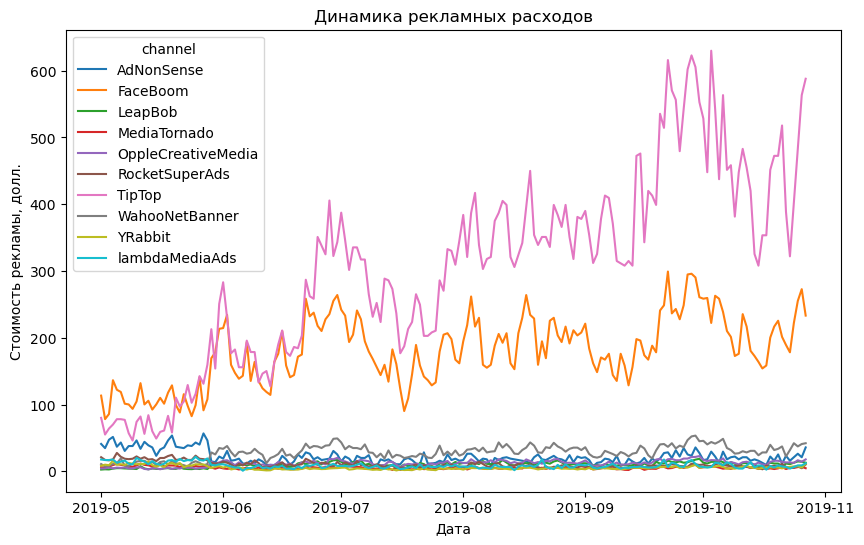

In [22]:
# Построим график динамики рекламных расходов
costs_dynamic = costs.pivot_table(index='dt', columns='channel', values='costs', aggfunc='mean')

costs_dynamic.plot(figsize=(10, 6))
plt.title('Динамика рекламных расходов')
plt.xlabel('Дата')
plt.ylabel('Стоимость рекламы, долл.')
plt.show()

На полученном графике мы получили сильные шумы. Воспользуемся функцией `filter_data()` для сглаживания графиков с помощью скользящих средних.

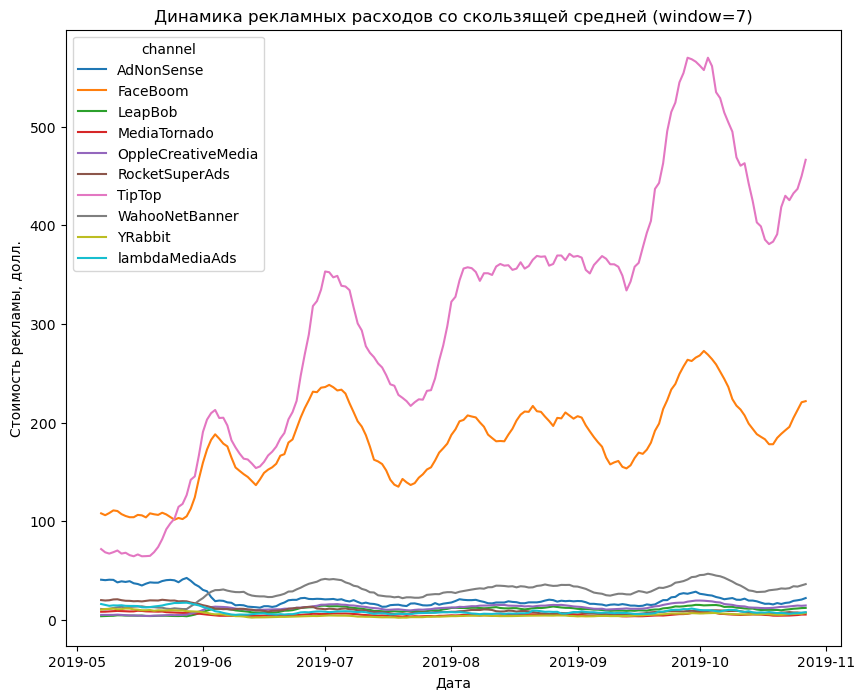

In [23]:
# Проведем "фильтрацию" динамики рекламных расходов с помощью скользящей средней
# Параметр window зададим равный неделе (7)
filter_data(costs_dynamic, 7).plot(figsize=(10, 8))
plt.title('Динамика рекламных расходов со скользящей средней (window=7)')
plt.xlabel('Дата')
plt.ylabel('Стоимость рекламы, долл.')
plt.show()

Самые рассходные являются каналы `TipTop` (затраты в день к концу года приблизились к 500 долларам) и `FaceBoom` (в среднем по 160 долларов в день). Разрыв между затратами на эти каналы в сравнении с остальными большой  
Заметна явная тенденция к увеличению бюджетов на эти рекламные каналы.

Графики по остальным каналам слились в сплошную линию. Отфильтруем датасет - уберем каналы с самыми большими рекламными расходами.

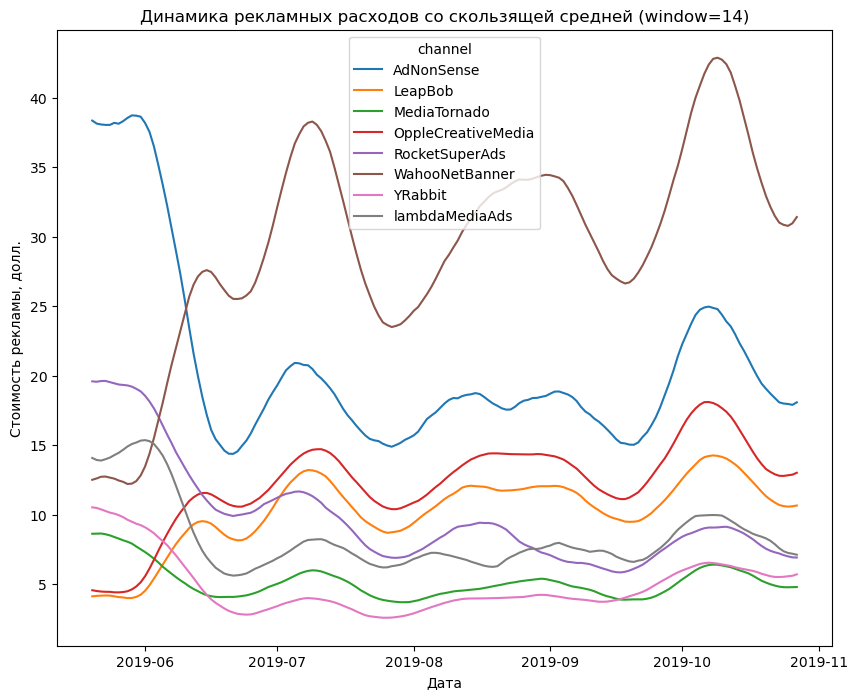

In [24]:
# Построим график с отфильтрованными данными
filter_data(costs_dynamic, 14).drop(columns=['TipTop', 'FaceBoom']).plot(figsize=(10, 8))
plt.title('Динамика рекламных расходов со скользящей средней (window=14)')
plt.xlabel('Дата')
plt.ylabel('Стоимость рекламы, долл.')
plt.show()

Среди оставшихся каналов лидирует `WahooNetBanner`, на который в среднем тратится по 35 долларов в день, для которого заметно небольшое увеличение бюджета со временем  
На канал `AdNonSense` тратится в среднем по 18 долларов в день, при том что он дает хороший трафик платящих пользователей. Видно, что со временем на этот канал стали выделять меньший бюджет  
По остальным каналам показатели еще ниже и отсутствует какая-либо сильная тенденция к увеличению или уменьшению рекламных бюджетов.

In [25]:
# Посчитаем среднюю стоимость привлечения пользователя по всем каналам
# Исключим канал organic, чтобы не искажать среднее значение
print('Средняя стоимость привлечения одного пользователя по всем каналам - {}$'.format(round(profiles.query('acquisition_cost > 0')['acquisition_cost'].mean(), 2)
               )
     )

Средняя стоимость привлечения одного пользователя по всем каналам - 1.13$


In [26]:
# Рассчитаем средний CAC для каждого источника трафика
(profiles.pivot_table(index='channel', values='acquisition_cost', aggfunc='mean')
        .sort_values(by='acquisition_cost', ascending=False)
).apply(lambda x: round(x, 2))

,acquisition_cost
channel,
TipTop,2.80
FaceBoom,1.11
AdNonSense,1.01
lambdaMediaAds,0.72
WahooNetBanner,0.60
RocketSuperAds,0.41
OppleCreativeMedia,0.25
YRabbit,0.22
MediaTornado,0.22


Дороже всего привлечение с канала `TipTop` - 2.8$  
В топ-3 по стоимости привлечения попадают так же каналы `FaceBoom` и `AdNonSense`

### Выводы

- На рекламные каналы `TipTop` и `FaceBoom` тратится большая часть рекламного бюджета и на них приходится самый высокий CAC
- Заметна тенденция к увеличению рекламного бюджета для канала `TipTop` со 100 долл. до 500 долл. в день

## 5. Анализ окупаемости рекламы

### Проанализируем общую окупаемость рекламы

Построим графики CAC, LTV и ROI без разбивок. Посмотрим на данные показатели в общем.

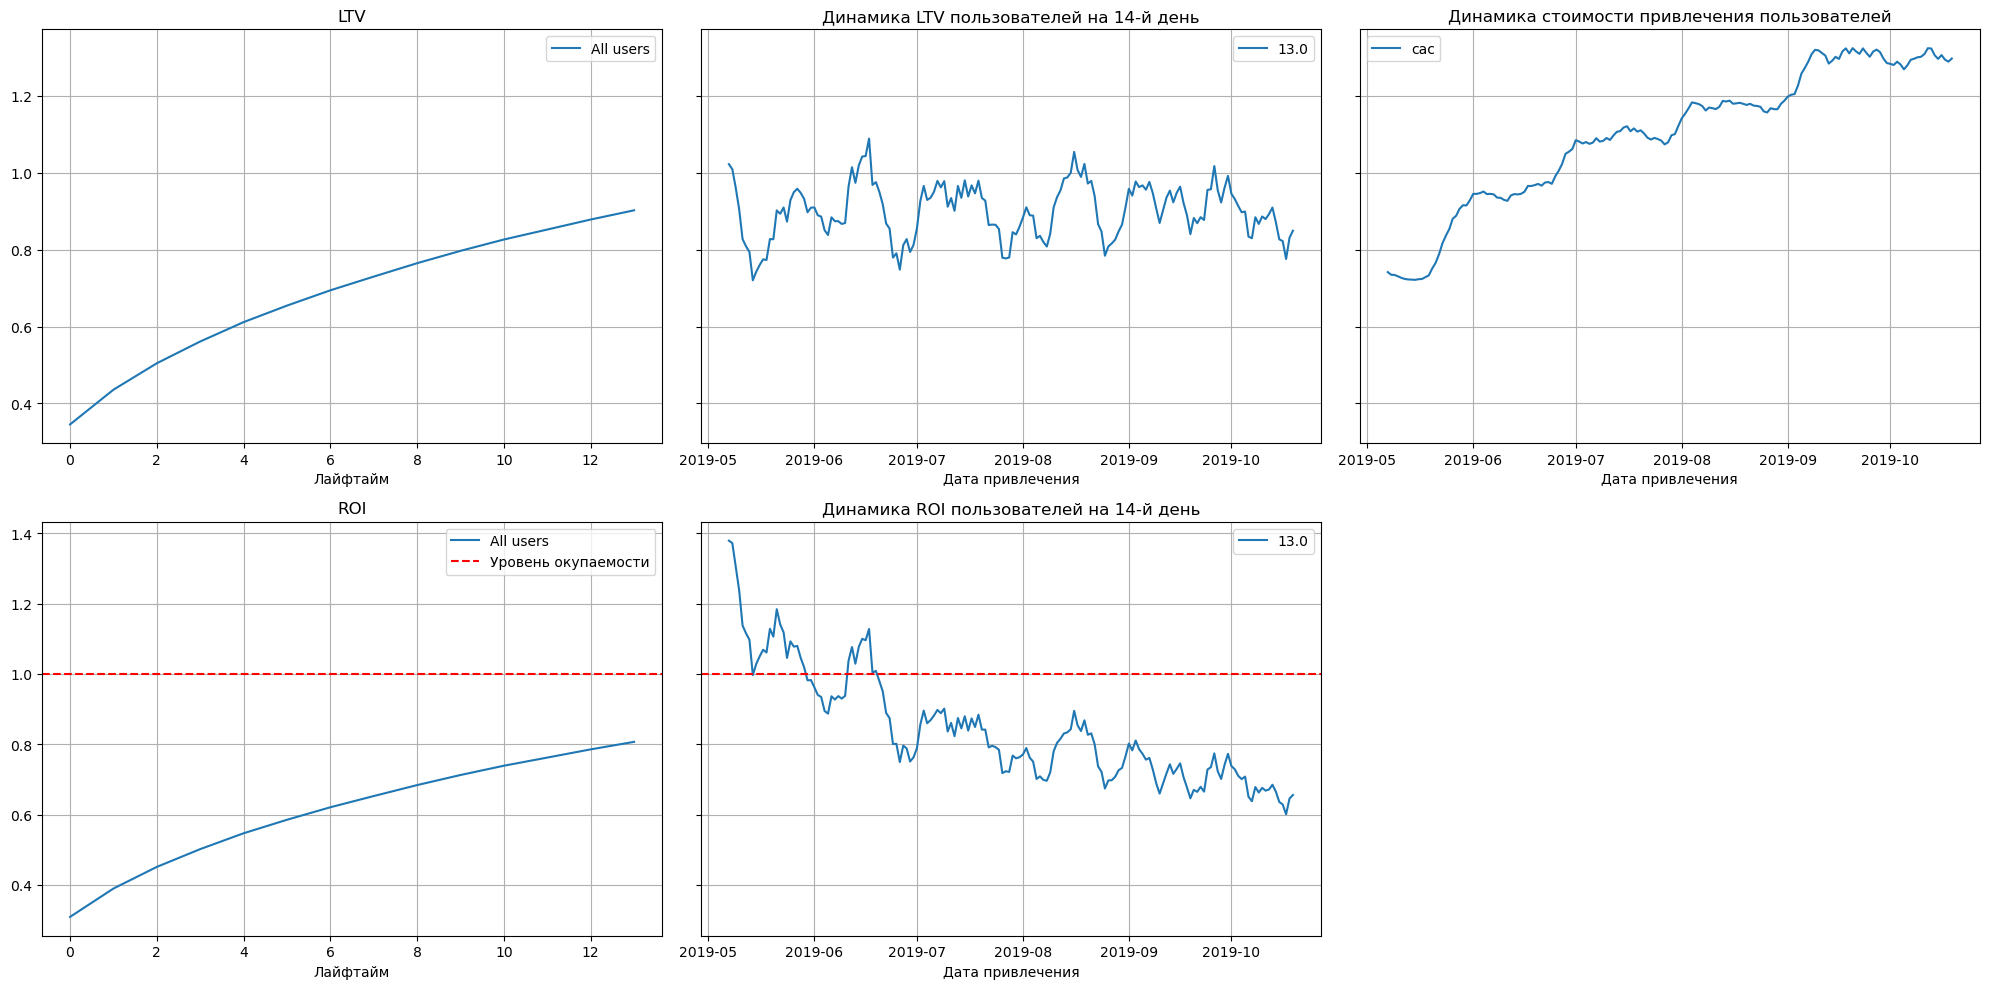

In [27]:
# Зададим  момент и горизонт анализа 
observation_date = datetime(2019, 11, 1).date()
horizon_days = 14

# Исключим рекламный канал 'organic' из профилей, чтобы иметь возможность оценить только эффект с оплаченной рекламы
profiles = profiles.query('channel != "organic"')

# Рассчитаем таблицы
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False
)

# Построим графики
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, window=7)

Из полученных графиков можно сделать следующие выводы:
- LTV на 14-й день имеет стабильную динамику в пределах от 0.8 до 1 доллара с покупателя
- Видно постоянное увеличение стоимости привлечения пользователей, которое к конце анализируемого периода достигает практически 1.1 долларов
- Фактически на конец 14-го дня не достигается окупаемость. ROI держится на уровне близком к 80%
- В динамике заметно падение ROI, которое может быть связано с увеличением рекламных расходов и в то же время уменьшением конверсии в платящих пользователей, либо низким показателем  удержания пользователей
- Так же мы видим, что с мая по середину июня ROI на конец 14-го дня было выше 1, т.е. в эти месяцы можно было судить об окупаемости рекламных затрат, после чего все стало ухудшаться

### Проанализируем окупаемость рекламы с разбивкой по рекламным каналам

Посмотрим на показатели в разрезе рекламных каналов.

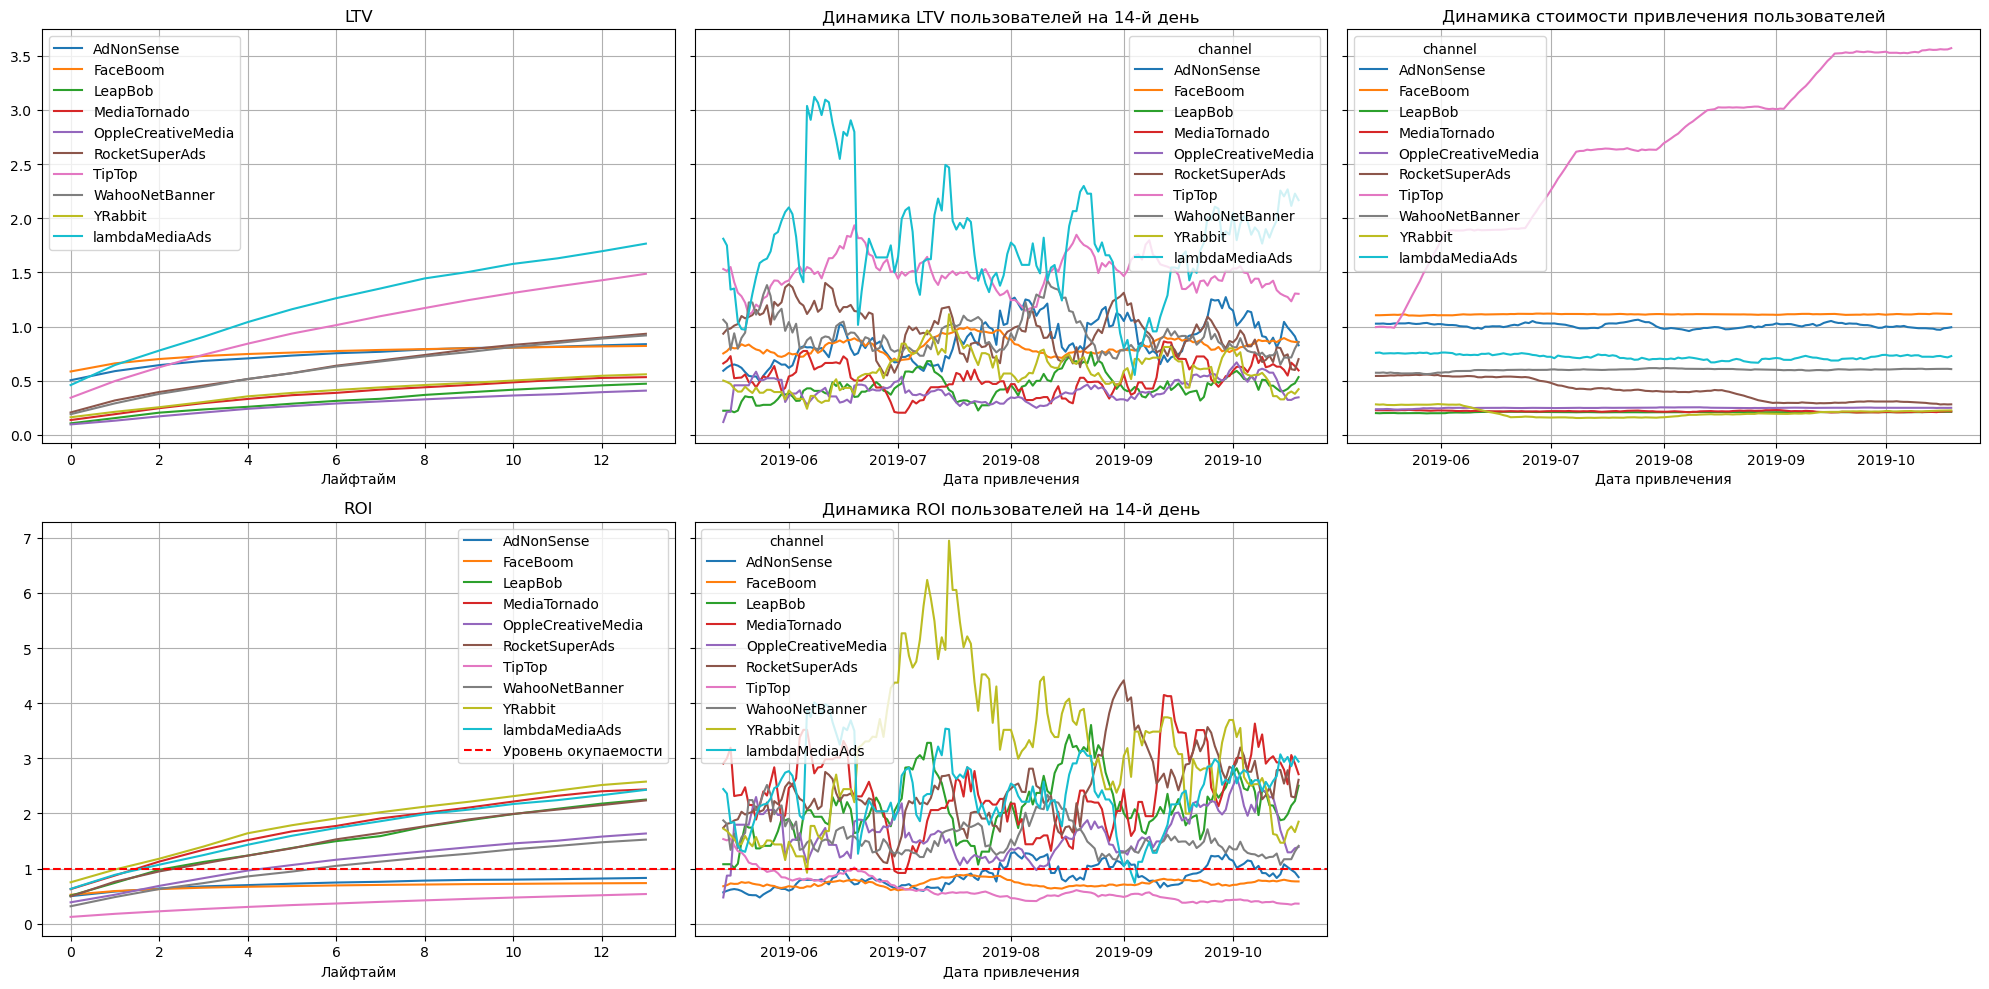

In [28]:
# Добавим разбивку по рекламным каналам
dimensions = ['channel']

# Рассчитаем таблицы
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions,
    ignore_horizon=False
)

# Построим графики
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, window=14)

- LTV на конец 14 дня больше 1 доллара приходится на каналы `lambdaMediaAds` и `TipTop`
- Заметен сильный рост CAC для канала `TipTop`, который значительно выше, чем LTV  по тому же каналу
- Окупаемости достигают все рекламные каналы кроме 3-х: `TipTop`, `FaceBoom`, `AdNonSense`

### Проанализируем окупаемость рекламы с разбивкой по устройствам

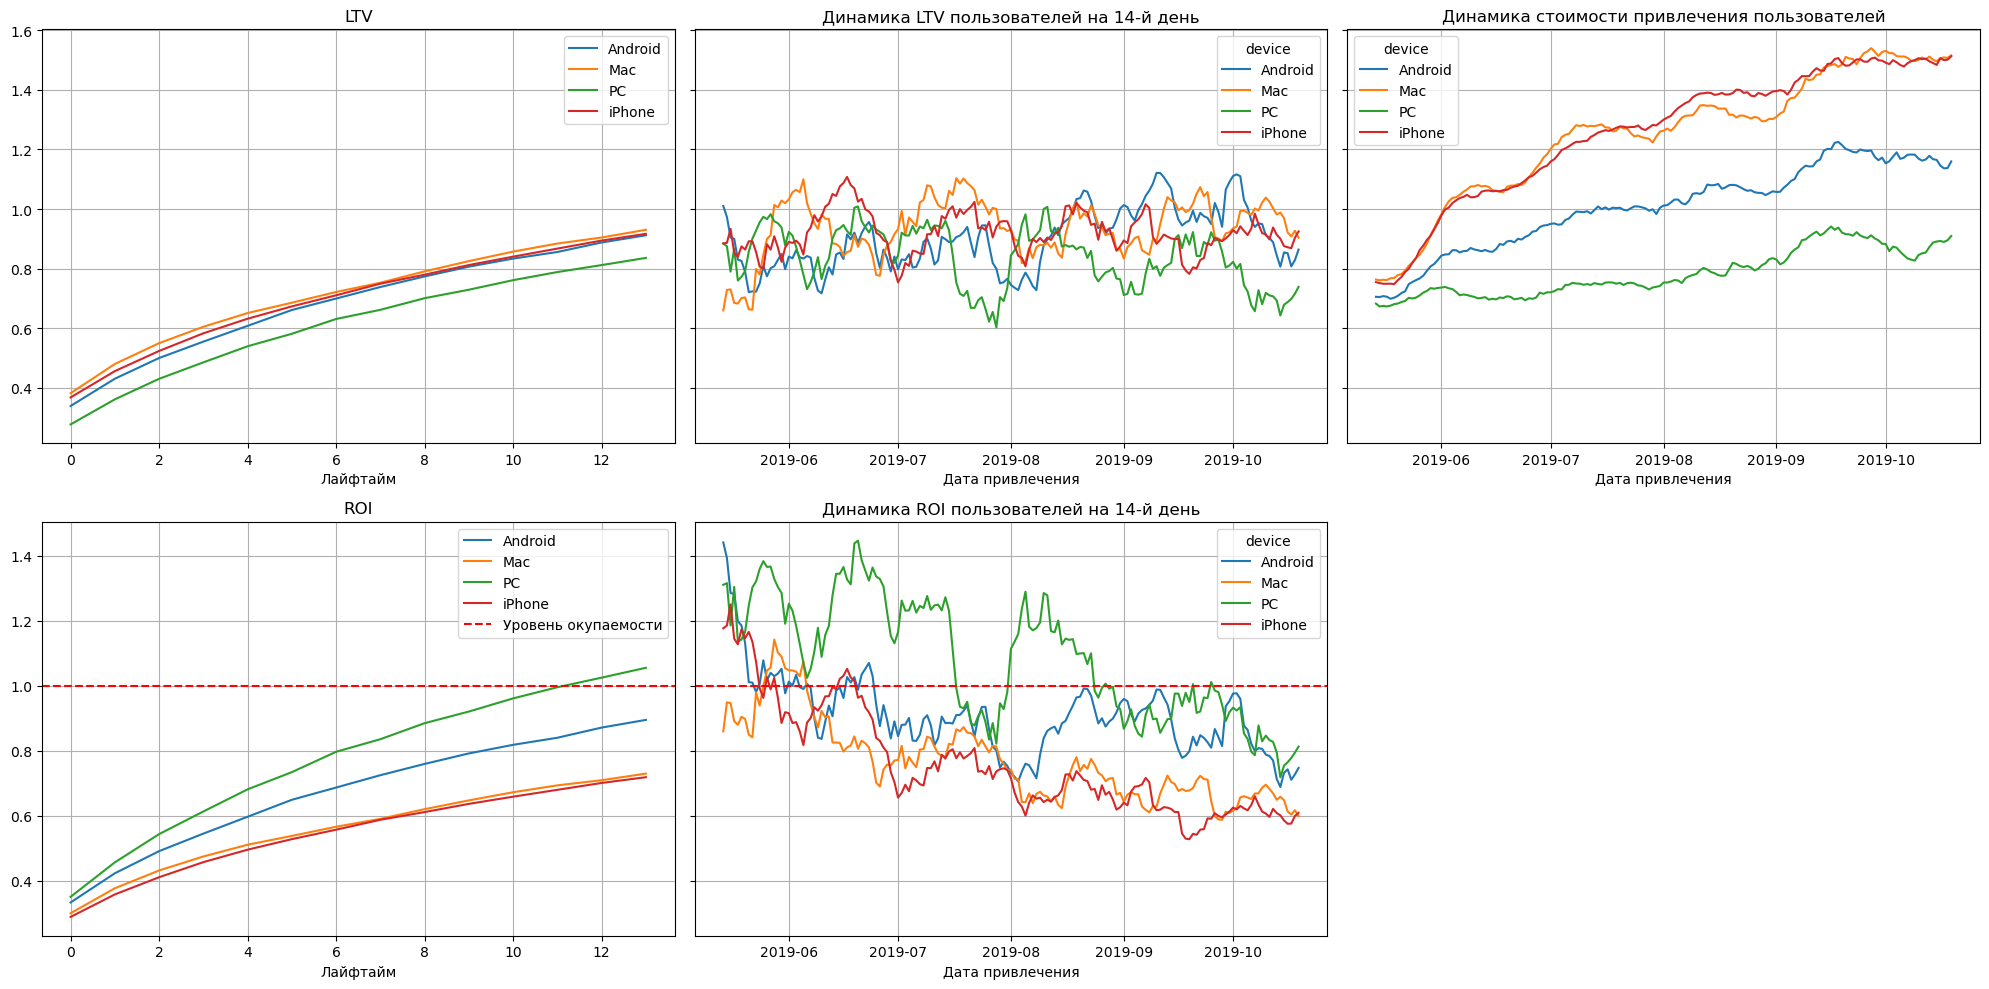

In [29]:
# Добавим разбивку по регионам
dimensions = ['device']

# Рассчитаем таблицы
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions,
    ignore_horizon=False
)

# Построим графики
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, window=14)

По устройствам следующая картина:
- Окупаются только пользователи устройства `PC`, при этом у этих пользователей самый низкий LTV в сравнении с другими устройствами. Хуже всех окупаемость у пользователей устройств `iPhone` и `Mac`.
- Видно увеличение стоимости привлечения пользователя по всем устройствам, что так же отражается и в динамике ROI на 14-й день, которая заметно снижается с увеличением рекламных бюджетов
- Самый низкий CAC у пользователей устройств `PC`, самый высокий у пользователей `iPhone` и `Mac`.

### Проанализируем окупаемость рекламы с разбивкой по странам

Посмотрим на показатели в разрезе регионов.

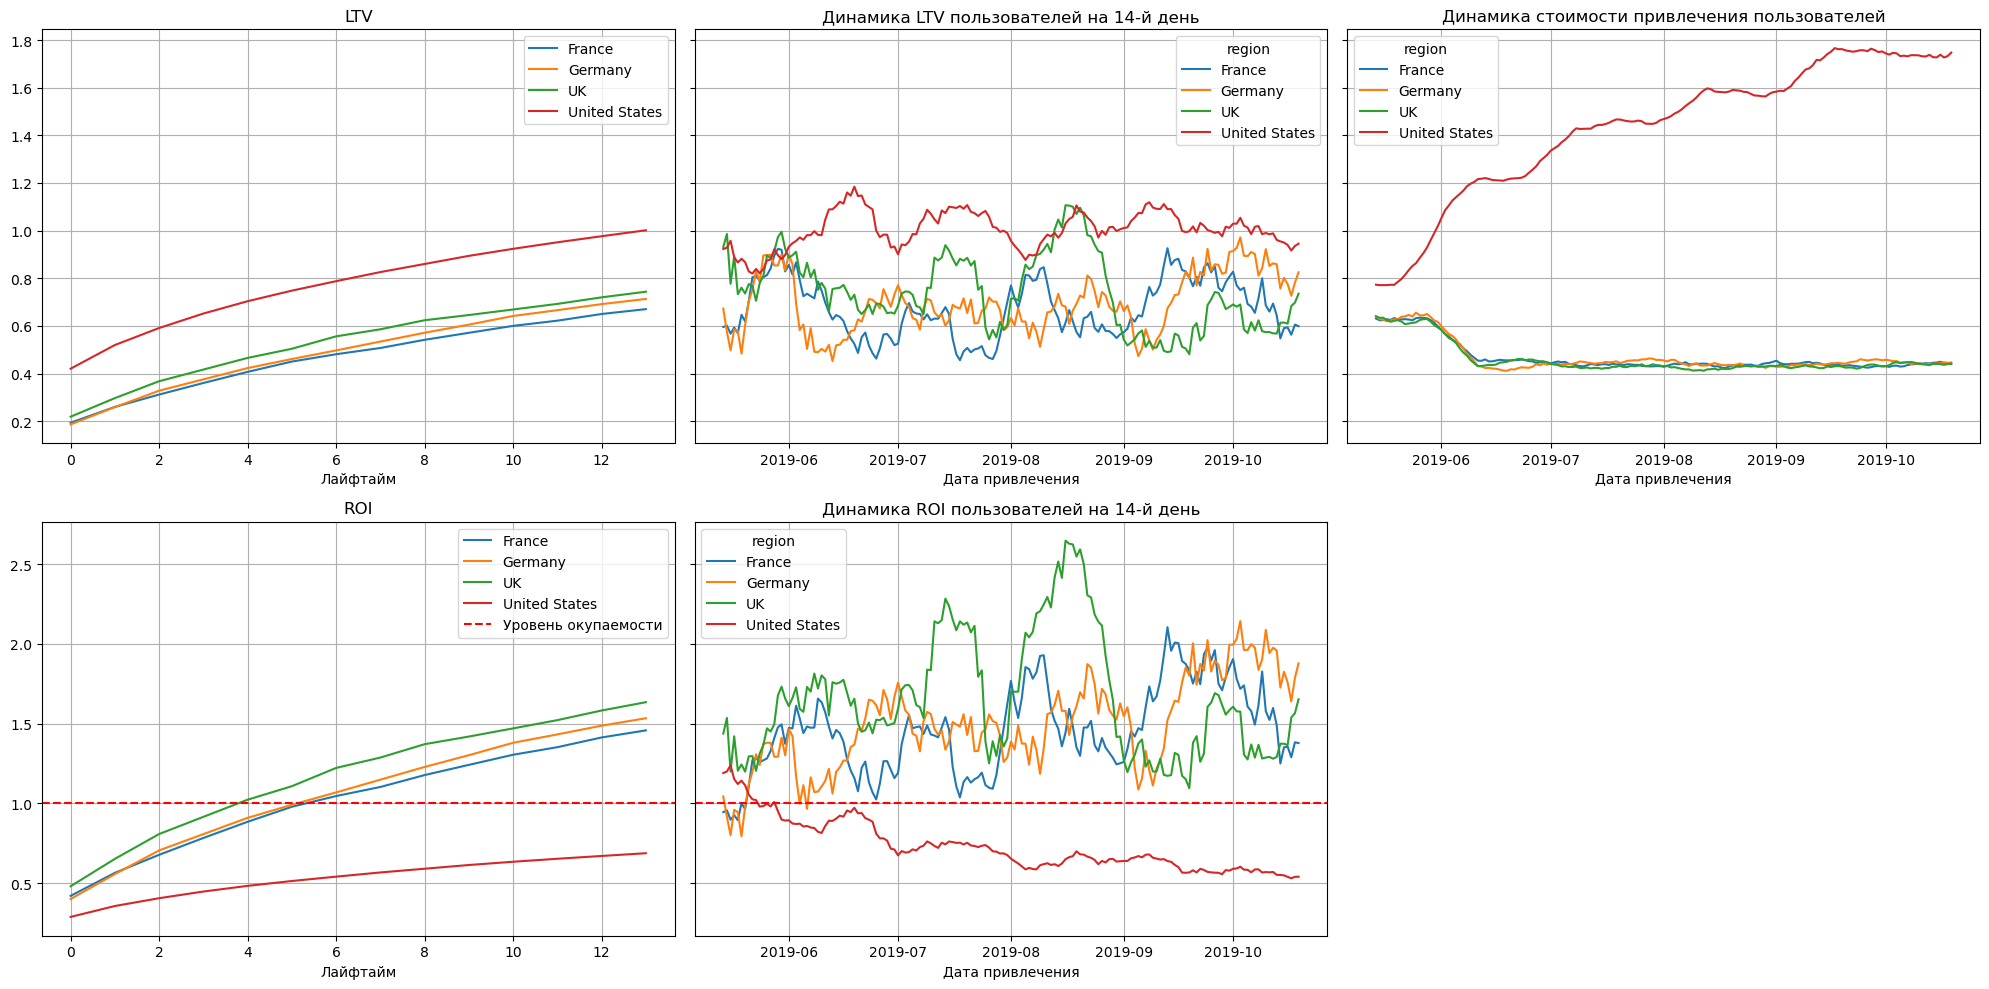

In [30]:
# Добавим разбивку по регионам
dimensions = ['region']

# Рассчитаем таблицы
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions,
    ignore_horizon=False
)

# Построим графики
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, window=14)

- Окупаются все регионы, кроме `United States`.
- CAC для региона `United States` почти в 4 раза выше, чем для остальных регионов. У остальных регионов CAC держится на уровне 0.4 доллара в день
- Заметно падение ROI в динамике на 14 день по региону `United States`, на которое определенно оказало влияние и кратное увеличение рекламного бюджета в те же периоды, когда начали увеличивать рекламный бюджет в данном регионе

Чтобы лучше понять в чем причина низкого ROI по региону `United States` посмотрим на графики конверсий в разбивке по регионам.

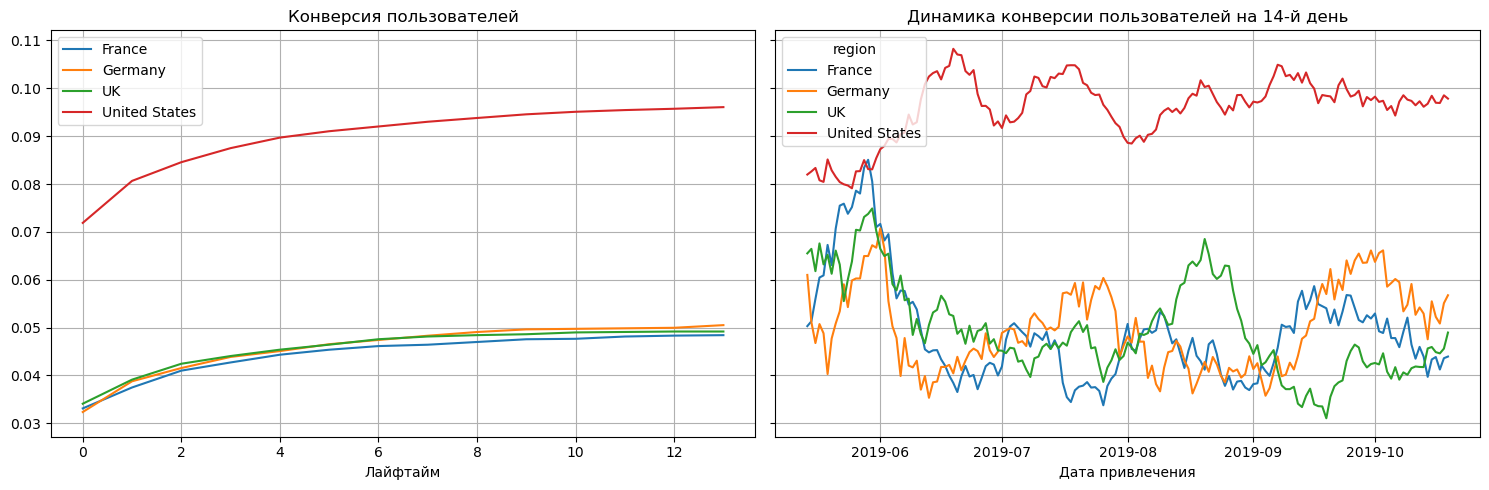

In [31]:
# Рассчитаем таблицы
conversion_raw, conversion, conversion_history = get_conversion(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions
)

# Построим графики
plot_conversion(conversion, conversion_history, horizon_days, window=14)

Конверсия по региону `United States` лидирует среди остальных и доходит до 0.095%, в то время как по остальным регионам конверсия практически не превышает 0.05%

С конверсией по региону все прекрасно. Посмотрим на процент удержания пользователей по регионам.

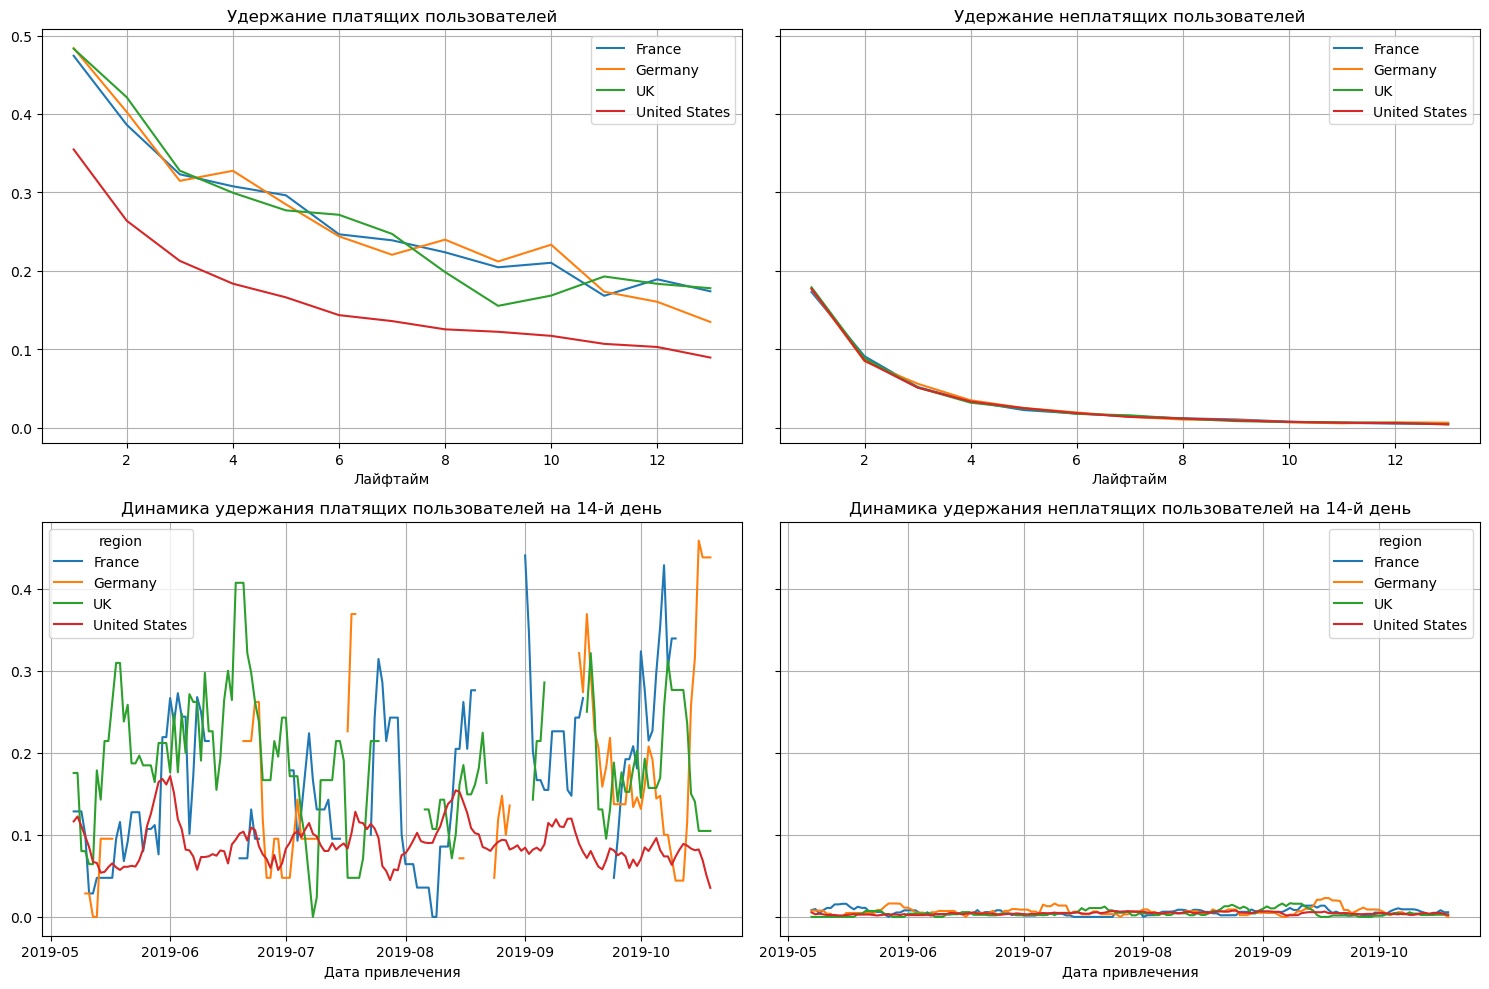

In [32]:
# Рассчитаем таблицы
retention_raw, retention, retention_history = get_retention(
    profiles,
    visits,
    observation_date,
    horizon_days,
    dimensions
)

# Построим графики
plot_retention(retention, retention_history, horizon_days, window=7)

- Регион `United States` хуже остальных удерживает платящих пользователей и имеет более низкие показатели удержания платящих в сравнении с остальными регионами, при этом разница с остальными регионами не такая значительная, чтобы настолько сильно повлиять на ROI
- По неплатящим пользователям удержание среди регионов практически идентичное

Видна проблема по региону `United States` - по данному региону приходит огромное количество новых пользователей с очень высокой стоимостью привлечения, довольно высокая доля из них конвертируется в продажи, но при этом пользователи очень быстро "утекают" из приложения, что непременно будет влиять и на LTV и на уменьшение ROI  
Посмотрим на `retention` в разрезе рекламных каналов.

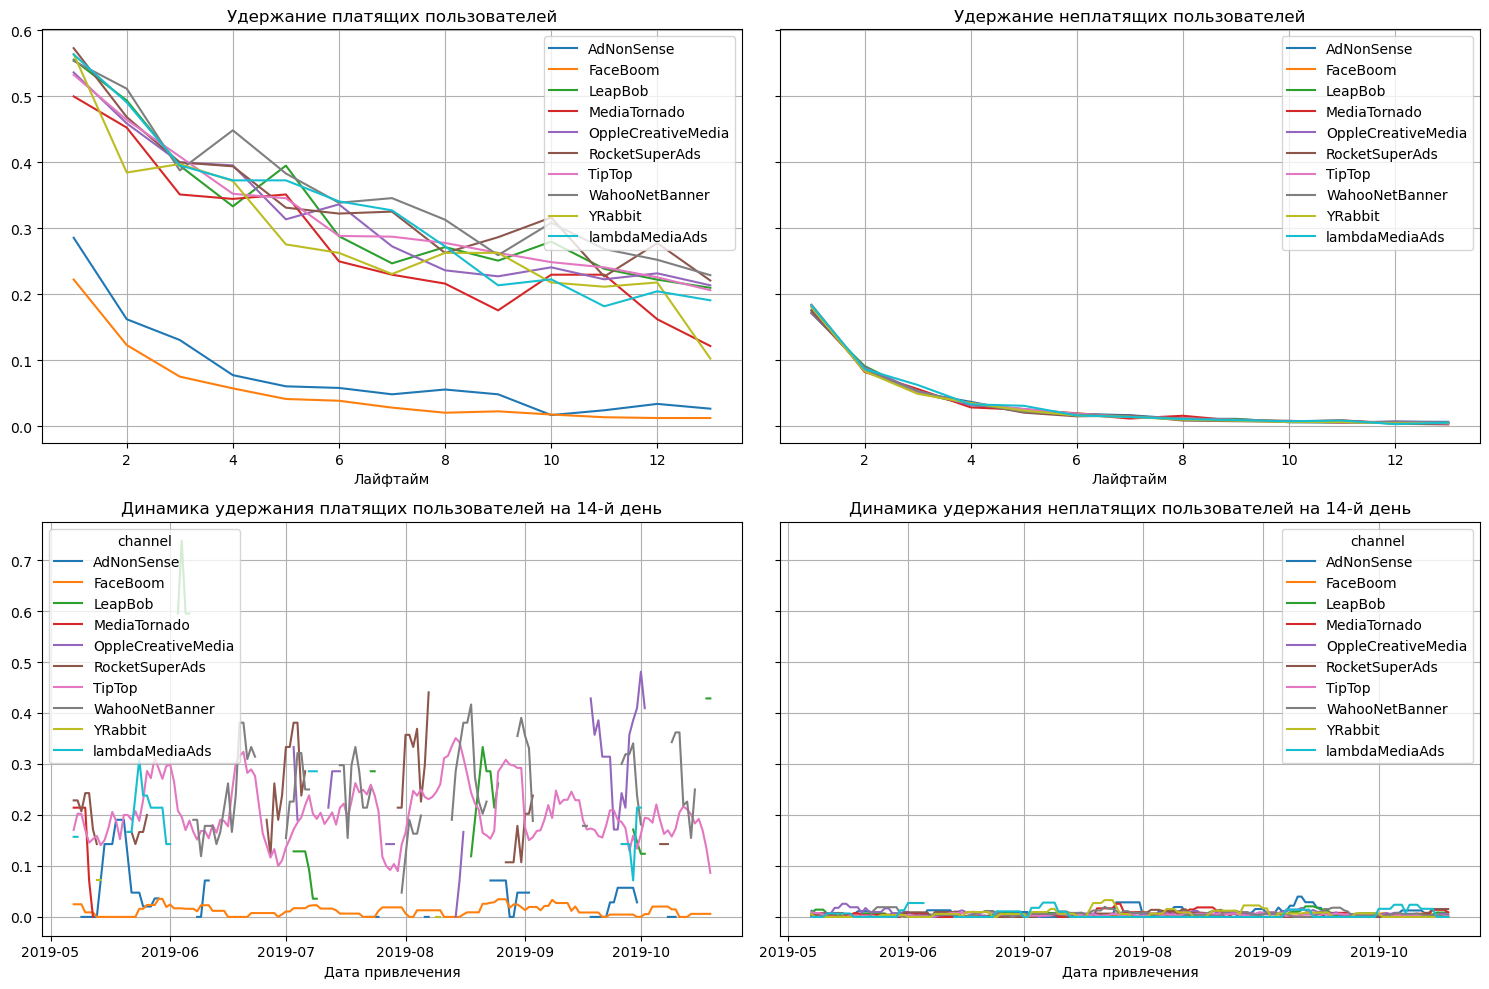

In [33]:
# Добавим разбивку по рекламным каналам
dimensions = ['channel']

# Рассчитаем таблицы
retention_raw, retention, retention_history = get_retention(
    profiles,
    visits,
    observation_date,
    horizon_days,
    dimensions
)

# Построим графики
plot_retention(retention, retention_history, horizon_days, window=7)

У нас есть 2 рекламных канала, которые имеют наихудшие показатели `retention` - `AdNonSense` и `FaceBoom`. Скорее всего пользователи пришедшие с этих каналов и дают низкий `retention` всему региону  
Проверим гипотезу и построим графики удержания без учета этих каналов

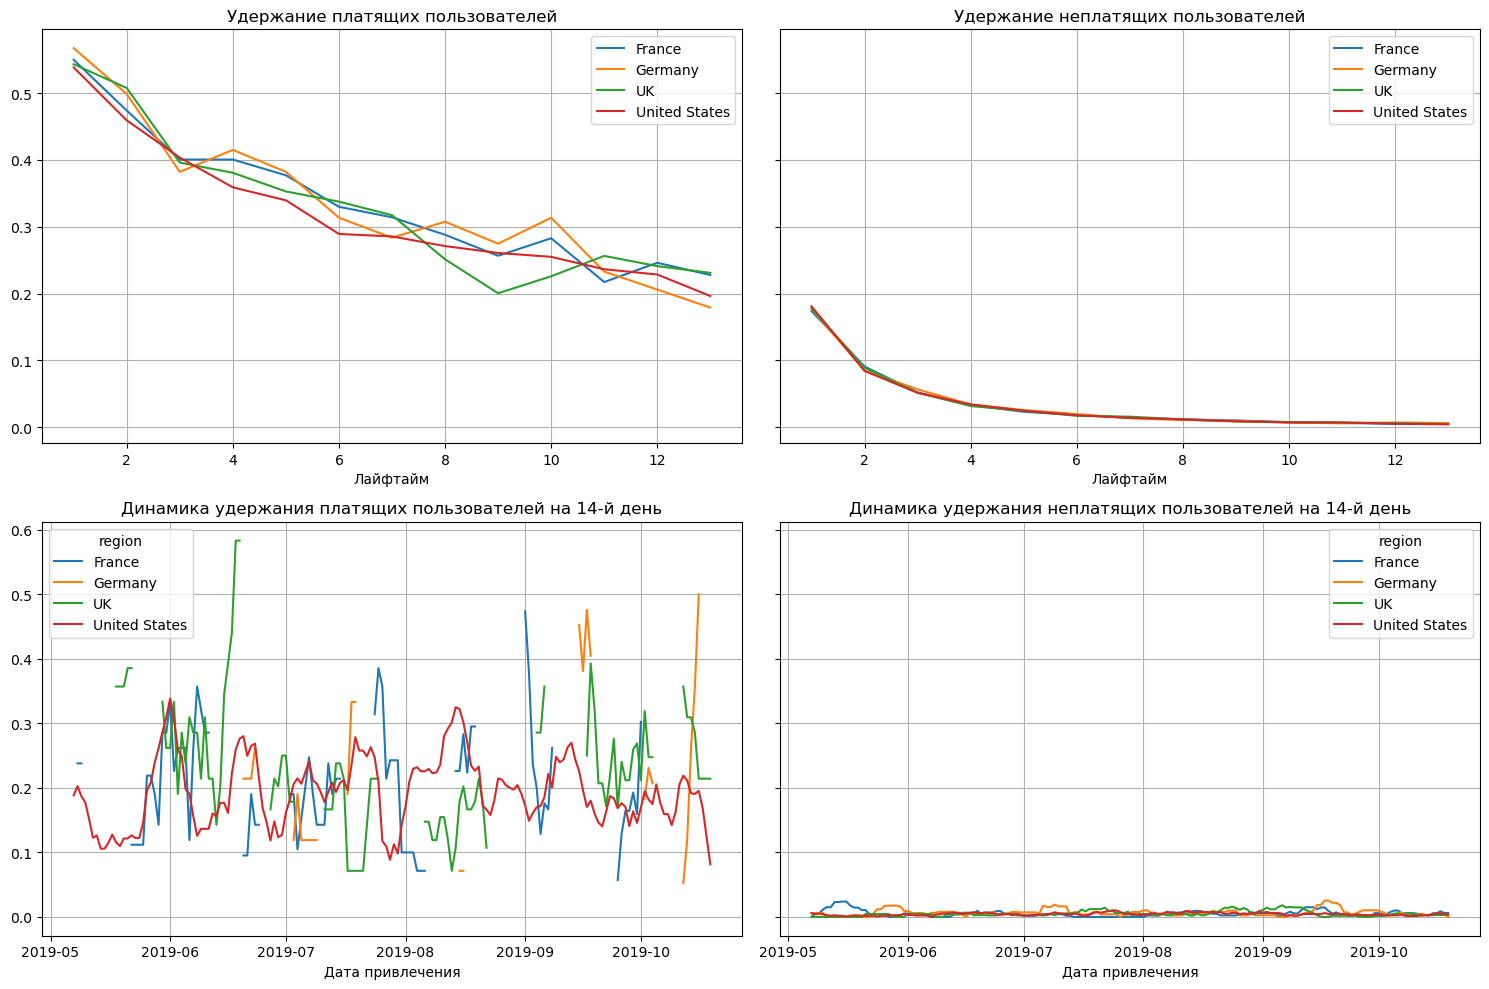

In [34]:
bad_channels = ['AdNonSense', 'FaceBoom']
dimensions = ['region']

# Рассчитаем таблицы
retention_raw, retention, retention_history = get_retention(
    profiles.query('channel not in @bad_channels'),
    visits,
    observation_date,
    horizon_days,
    dimensions
)

# Построим графики
plot_retention(retention, retention_history, horizon_days, window=7)

Наша гипотеза подтвердилась - без этих рекламных каналов мы получаем средние уровни `retention` по региону `United States`.

Посмотрим на графики конверсий с разбивкой по рекламным каналам.

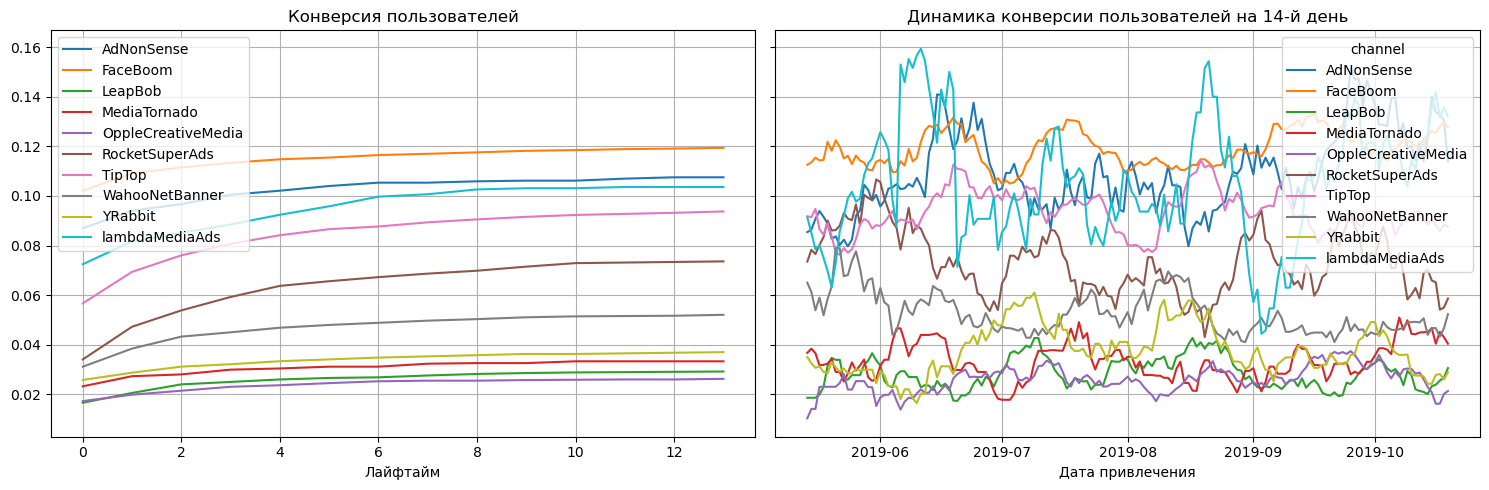

In [35]:
dimensions = ['channel']

# Рассчитаем таблицы
conversion_raw, conversion, conversion_history = get_conversion(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions
)

# Построим графики
plot_conversion(conversion, conversion_history, horizon_days, window=14)

Снова видим, что конверсия в порядке для "убыточных" рекламных каналов.

Неоходимо изучить, почему низкое удержание двух рекламных каналов влияет так сильно только на один регион. Изучим расспределение между регионами и рекламными каналами.

In [36]:
# Построим сводную таблицу,, которая будет отображать в каких регионах какие рекламные каналы настроены для привлечения пользователей
profiles.pivot_table(index='channel', columns='region', values='acquisition_cost', aggfunc='count')

region,France,Germany,UK,United States
channel,,,,
AdNonSense,1366.0,1219.0,1295.0,NaN
FaceBoom,NaN,NaN,NaN,29144.0
LeapBob,2988.0,2519.0,3046.0,NaN
MediaTornado,NaN,NaN,NaN,4364.0
OppleCreativeMedia,2991.0,2562.0,3052.0,NaN
RocketSuperAds,NaN,NaN,NaN,4448.0
TipTop,NaN,NaN,NaN,19561.0
WahooNetBanner,2971.0,2579.0,3003.0,NaN
YRabbit,NaN,NaN,NaN,4312.0


У нас имеется лишь несколько рекламных каналов, которые работают только в одном регионе `United States`, в том числе и один из "убыточных" каналов - `TipTop`.

Посмотрим на графики удержания и конверсии с разбивкой по устройствам.

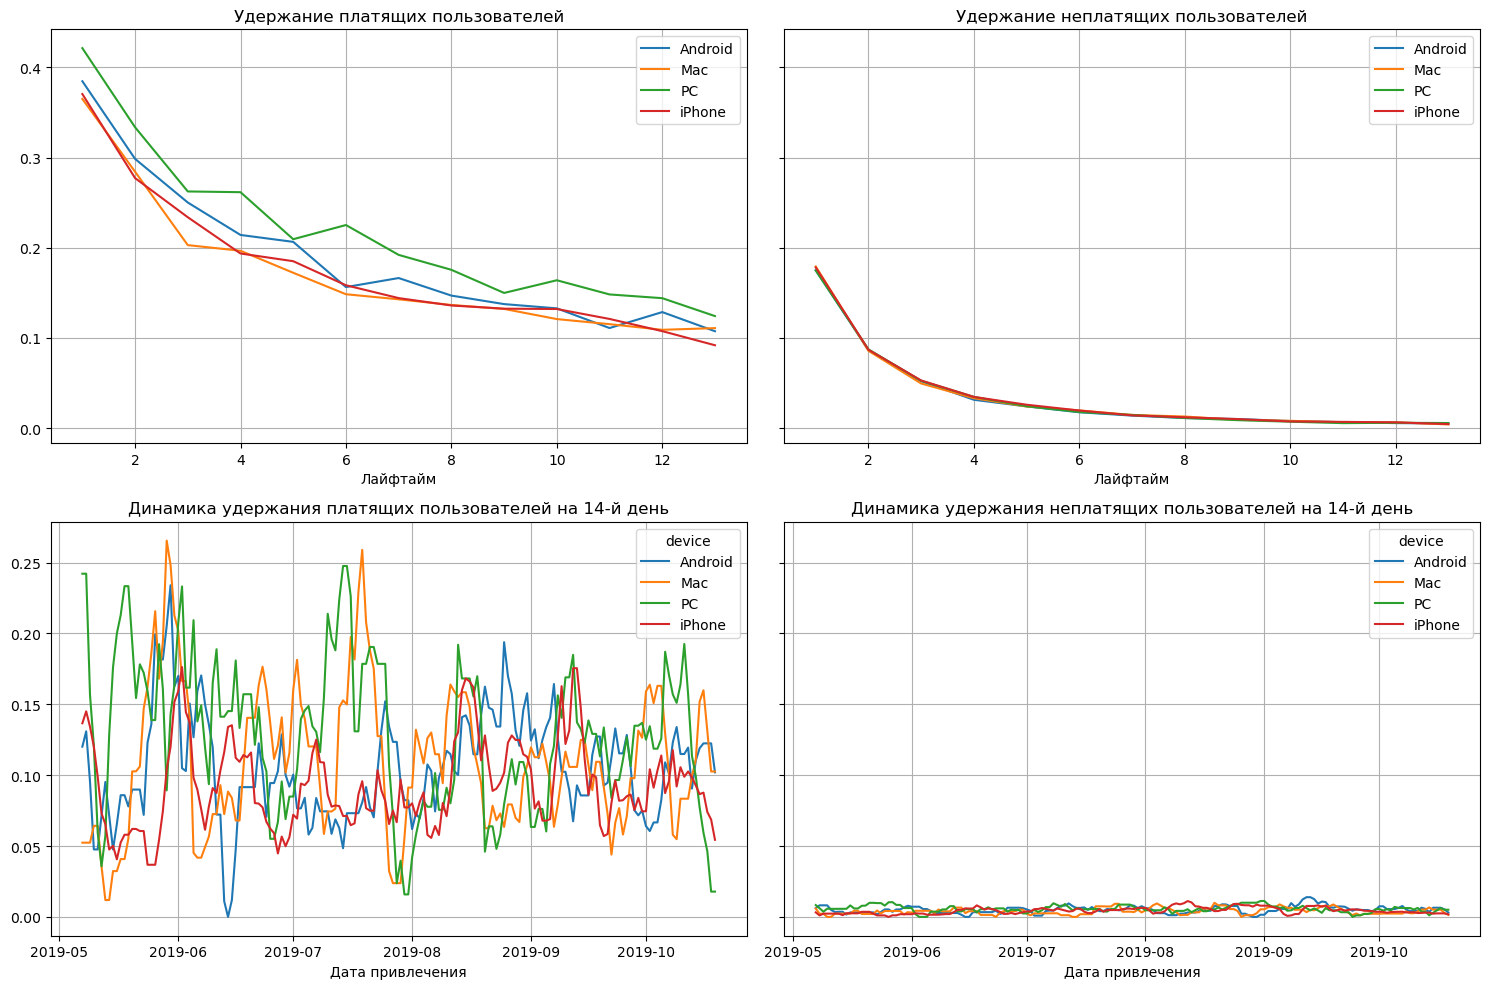

In [37]:
# Добавим разбивку по устройствам
dimensions = ['device']

# Рассчитаем таблицы
retention_raw, retention, retention_history = get_retention(
    profiles,
    visits,
    observation_date,
    horizon_days,
    dimensions
)

# Построим графики
plot_retention(retention, retention_history, horizon_days, window=7)

Удержание у всех устройств практически на одинаковом уровне. Чуть лучше остальных удерживаются пользователи `PC`.

Посмотрим конверсию по устройствам.

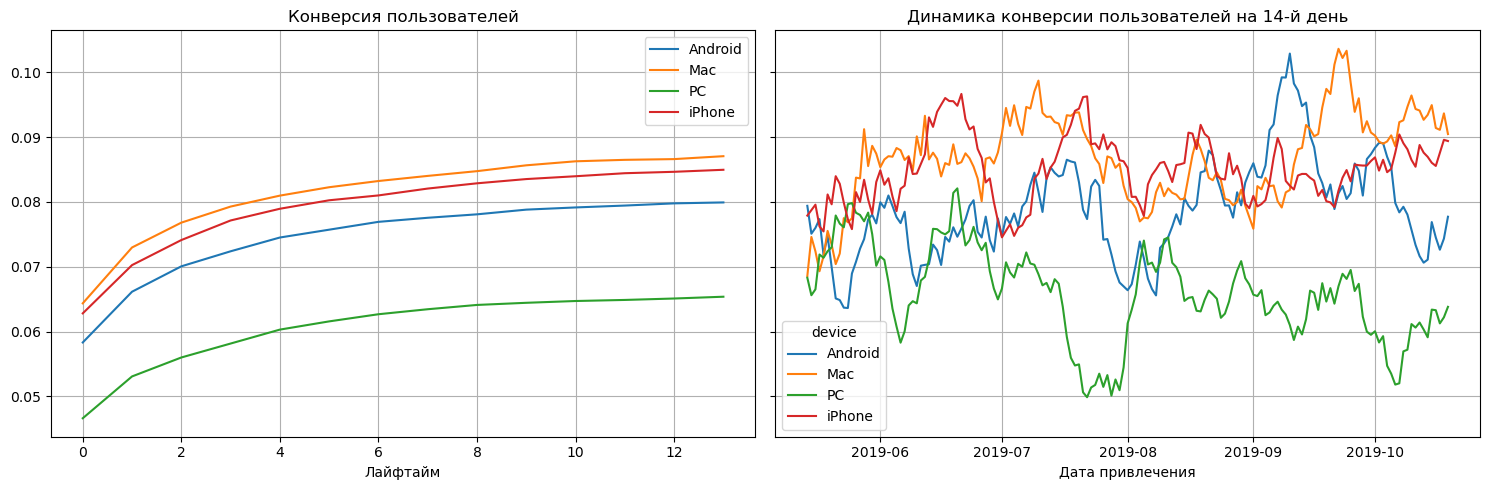

In [38]:
dimensions = ['device']

# Рассчитаем таблицы
conversion_raw, conversion, conversion_history = get_conversion(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions
)

# Построим графики
plot_conversion(conversion, conversion_history, horizon_days, window=14)

Лучше всего конвертируются в платящих пользователи устройств `Mac` и `iPhone`, хуже всего пользователи `PC`.

### Выводы

- Реклама не окупается за ожидаемые 2 недели. ROI к концу второй недели достигает 80%
- У региона `United States` сильно возрасла стоимость привлечения новых пользователей. При этом в данном регионе довольно низкие  показатели retention, и несмотря на высокий уровень конверсии, LTV не перебивает рекламные затраты, из-за чего падает показатель ROI по данному региону.
- Рекламные каналы `FaceBoom`, `AdNoSense` и `TipTop` не окупаются. CAC у данных каналов выше, чем LTV пользователей привлеченных через них.
- Пользователи с устройств `Mac` и `iPhone` конвертируются в платящих пользователей лучше остальных.

## Общие выводы

В результате анализа можно описать следующие проблемы и предложить следующие рекомендации:
- Для рекламных каналов `FaceBoom`, `AdNoSense` и `TipTop` необходимо пересмотреть основные цели: при текущей стоимости привлечения пользователей данные каналы являются убыточными. Чтобы каналы могли окупаться стоит придерживаться следующих уровней CAC: для каналов `FaceBoom` и `AdNoSense` - не более 0.7 долларов за пользователя, для `TipTop` - не более 1.5 доллара за пользователя.
- Для пользователей региона `United States`, привлеченных через рекламный канал `FaceBoom`, необходимо проанализировать удержание пользователей. По какой-то причине именно эти пользователи плохо удерживаются в приложении, что так же влияет на LTV и конечный ROI. Возможно этот канал таргетирован на платежеспособную аудиторию, которая охотно пробует различные продукты (что объясняло бы и высокую конверсию), но при этом она не является целевой, из-за чего такие пользователи очень быстро перестают продуктом пользоваться.

### Причины неэффективности

Основные причины неэффективности рекламных каналов заключаются в увеличении стоимости привлечения пользователя по рекламному каналу `TipTop` и по привлечению некачественной аудитории, которая очень плохо удерживается, по каналам `FaceBoom`, `AdNonSense`.

На первую проблему указывают следующие моменты:
1. Для канала `TipTop` LTV достигает 1.5 долларов с привлеченного пользователя.
2. Стоимость привлеченного пользователя за изучаемый период выросла с 1 долл. до 3.5 долл. за привлечение одного пользователя.
3. В динамике LTV держится на одном и том же уровне.
4. Динамика показателя ROI на 14-й день по данному каналу снизилась со 160% до 40%
5. Retention пользователей находится на уровне всех остальных каналов.
6. Конверсия пользователей держится на хорошем уровне.

На вторую проблему указывает следующее:
1. CAC по обим каналам держался неизменным весь период и практически на одном уровне - 1.1 долл. за привлеченного пользователя.
2. LTV для обоих каналов на конец 2-й недели достигает уровня 0.9 долл. с пользователя.
3. ROI практически достигает 90%. Если смотреть на ROI в динамике, то видно, что периодически данные каналы пересекают порог окупаемости.
4. У данных каналов самый высокий процент конверсии - в районе 11-12%.
5. Retention к концу 2-й недели достигает среднего уровня, но на графике заметно, что в течении 2-х недель очень много пользователей "утекает" именно по этим 2-м каналам.

### Рекомендации

Из рекомендаций можно выделить следующие пункты:<br>
Для рекламного канала `TipTop`<br>
- С учетом LTV равному 1.5 долл. с пользователя основной рекомендацией будет необходимость удерживать стоимость привлечения пользователя ниже данного уровня для достижения окупаемости по каналу.

Для рекламных каналов `FaceBoom` и `AdNonSense`<br>
- Для достижения окупаемости по данным каналам не хватает совсем немного. Достичь окупаемости можно либо путем снижения стоимости привлечения пользователя до уровня ниже 0.9 долл., либо увеличением процента удержания пользователей в продукте - вероятно есть проблема с качеством аудитории на которую настроена реклама по этим каналам.